In [18]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, SimpleRNN

In [3]:
df = pd.read_csv('./train.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df.shape

(7613, 5)

In [6]:
df = df[['text','target']]

In [7]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:

max_length= max(df['text'].apply(lambda x: len(x.split())).values)

max_length



31

In [9]:
df.describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [10]:
df.groupby('target').describe().T

target                                                       0  \
text count                                                4342   
     unique                                               4315   
     top     The Prophet (peace be upon him) said 'Save you...   
     freq                                                    4   

target                                                       1  
text count                                                3271  
     unique                                               3206  
     top     11-Year-Old Boy Charged With Manslaughter of T...  
     freq                                                   10

target
0    4342
1    3271
Name: count, dtype: int64

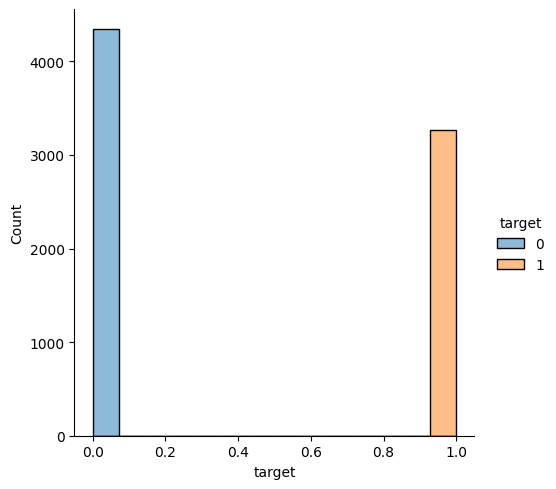

In [11]:

sns.displot(data=df, x='target', hue='target')
df['target'].value_counts()






In [15]:
import string
import re


def clean_text(txt):

    
    contraction_dict = {
        "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
        "could've": "could have", "couldn't": "could not", "didn't": "did not",
        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
        "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have"
    }

    
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    
    txt = replace_contractions(txt)

    
    txt = "".join([char for char in txt if char not in string.punctuation])

    
    txt = re.sub(r'[0-9]+', '', txt)

    
    txt = txt.lower()

    
    txt = re.sub(r"\#", "", txt)  
    txt = re.sub(r"http\S+", "URL", txt)
      
    txt = re.sub(r"@", "", txt)  

    
    txt = re.sub(r"\s{2,}", " ", txt)

    
    words = txt.split()


    
    
    words = [word for word in words if word.isalpha()]

   
    cleaned_text = ' '.join(words)

    return cleaned_text


df['text'] = df['text'].apply(lambda txt: clean_text(txt))

df.head()


,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in ...,1
4,just got sent this photo from ruby alaska as s...,1


In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(df['text'].values, df['target'].values, shuffle=True, test_size=0.1)
 



In [36]:

max_len = max(df['text'].apply(lambda x: len(x.split())).values)
max_words = 20000




tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')


tokenizer.fit_on_texts(xtrain)


xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xtest_seq = tokenizer.texts_to_sequences(xtest)


xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)



word_index = tokenizer.word_index
print(f'OOV Token index: {word_index["<OOV>"]}')


OOV Token index: 1


In [60]:
print('Shape of training tensor: ', xtrain_pad.shape)
print('Shape of testing tensor: ', xtest_pad.shape)

Shape of training tensor:  (6851, 31)
Shape of testing tensor:  (762, 31)


In [25]:
import numpy as np

embedding_vectors = {}
with open('./glove.6B.300d.txt','r',encoding='utf-8') as file: 
    for row in file:
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vectors[word] = weights
print(f"Size of vocabulary in GloVe: {len(embedding_vectors)}")

Size of vocabulary in GloVe: 400000


In [38]:
emb_dim = 300
vocab_len = max_words if max_words is not None else len(word_index)+1
embedding_matrix = np.zeros((vocab_len, emb_dim))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embedding_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)
print(f'Some out of valubulary words: {oov_words[0:5]}')
print(f'{oov_count} out of {vocab_len} words were OOV.')

Some out of valubulary words: ['<OOV>', 'prebreak', 'yearold', 'nowplaying', 'bestnaijamade']
4358 out of 20000 words were OOV.


In [28]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)
    
    return embedding_matrix


In [29]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('./glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

In [31]:
vocab_size = len(word_index) + 1

In [99]:
x_train, x_val, y_train, y_val = train_test_split(xtrain, ytrain, test_size=0.1)


In [100]:

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')


tokenizer.fit_on_texts(x_train)


x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)


x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = sequence.pad_sequences(x_val_seq, maxlen=max_len)

In [101]:
print('Shape of training tensor: ', x_train_pad.shape)
print('Shape of validation tensor: ', x_val_pad.shape)

Shape of training tensor:  (6165, 31)
Shape of validation tensor:  (686, 31)


In [109]:
y_train.shape

(6165,)

In [105]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                    trainable=True))  

model1.add(Bidirectional(LSTM(128, return_sequences = False)))  
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))  

In [106]:
model1.build(input_shape=(None, max_len))

In [107]:
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 31, 300)        │     4,704,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,144,453 (19.62 MB)

 Trainable params: 5,144,453 (19.62 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [110]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model1.fit(x_train_pad,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (x_val_pad, y_val),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
193/193 - 25s - 131ms/step - accuracy: 0.6016 - loss: 0.6699 - val_accuracy: 0.6108 - val_loss: 0.6347
Epoch 2/30
193/193 - 21s - 109ms/step - accuracy: 0.7118 - loss: 0.5583 - val_accuracy: 0.7638 - val_loss: 0.4849
Epoch 3/30
193/193 - 21s - 110ms/step - accuracy: 0.8576 - loss: 0.3486 - val_accuracy: 0.7945 - val_loss: 0.4666
Epoch 4/30
193/193 - 21s - 108ms/step - accuracy: 0.9273 - loss: 0.2047 - val_accuracy: 0.7974 - val_loss: 0.4997
Epoch 5/30
193/193 - 21s - 109ms/step - accuracy: 0.9557 - loss: 0.1308 - val_accuracy: 0.8003 - val_loss: 0.6288


In [ ]:
import keras.backend as K
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
def f1_score_(y_true, y_pred):
    y_pred = K.round(y_pred)  
    return K.variable(f1_score(y_true, y_pred, average='weighted'))


In [111]:
from sklearn.metrics import f1_score


y_pred = model1.predict(xtest_pad)
y_pred_classes = np.argmax(y_pred, axis=1)  

f1 = f1_score(ytest, y_pred_classes, average='weighted')
print(f'F1 Score: {f1}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
F1 Score: 0.40558122929847873


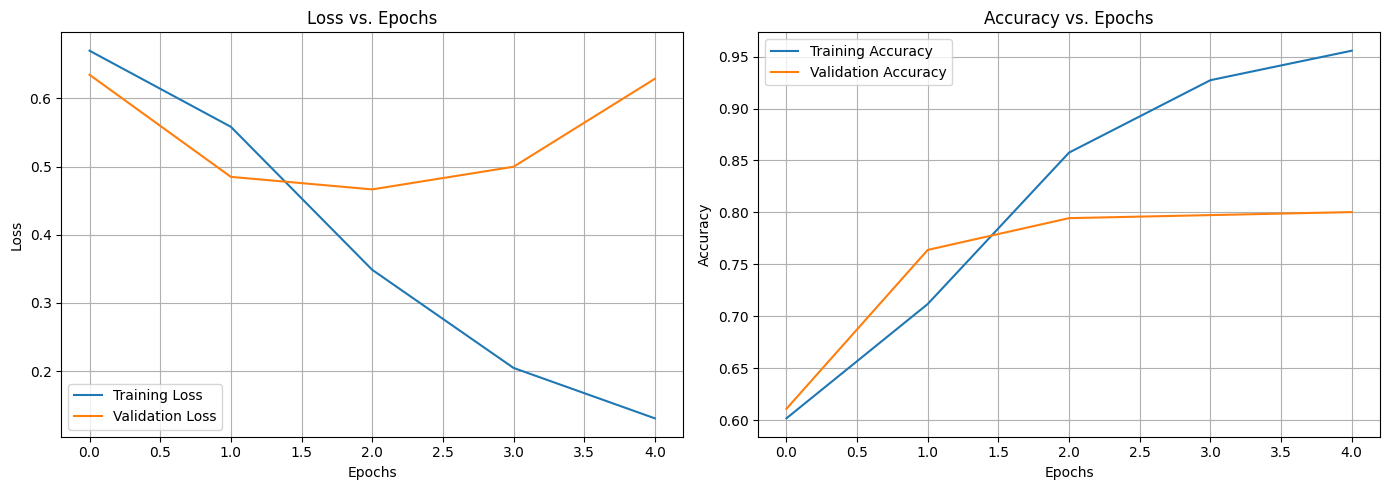

In [112]:
import matplotlib.pyplot as plt
# Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [113]:

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]


print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Training Accuracy: 0.9557
Final Validation Accuracy: 0.8003


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


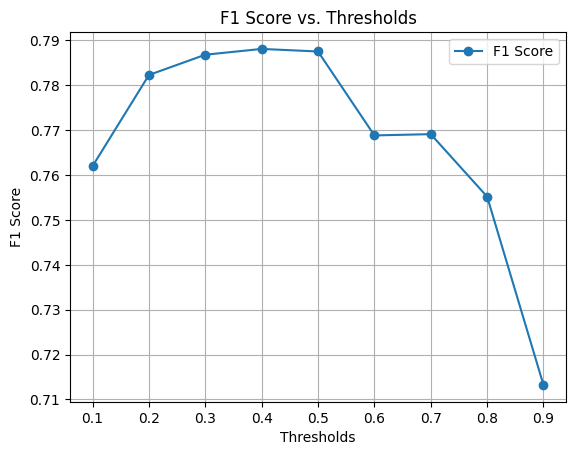

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


thresholds = np.arange(0.1, 1.0, 0.1)
f1_scores = []


for threshold in thresholds:
    
    y_pred = model1.predict(xtest_pad)
    
    
    y_pred_classes = (y_pred > threshold).astype(int)  
    
    
    f1 = f1_score(ytest, y_pred_classes, average='weighted')
    
    
    f1_scores.append(f1)


plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('F1 Score vs. Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()